In [ ]:
# ============================================================================
# Our Training Ground
# Gwade Steve
# MTTL and Application to Malaria Detection
# April 2025
# ============================================================================

In [1]:
# Importing libraries
import os
import pprint
import sys
import pickle
import seaborn as sns
from collections import defaultdict, Counter
import copy
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import json
import traceback
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import FancyBboxPatch
import matplotlib.ticker as mtick
import textwrap
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import openpyxl
from openpyxl.styles import Font, PatternFill, Alignment, Border, Side
from openpyxl.worksheet.table import Table, TableStyleInfo
from openpyxl.utils import get_column_letter
from datetime import datetime
from typing import Dict, List, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_recall_fscore_support
from scipy.stats import pearsonr
import time
from tqdm import tqdm

utilities_path = '../src/utils'
if utilities_path not in sys.path:
    sys.path.append(utilities_path)
    print(f"Added '{utilities_path}' to system path.")
else:
    print(f"'{utilities_path}' is already in the system path.")

from DataUtils import FlexibleMalariaDataset, set_seeds, seed_worker
from model import create_model_for_task, validate_model_setup, create_multitask_model
from Components import *
from Losses import *
from STLTrainer import *
from experiment_manager import ExperimentManager
from Evaluator import AdvancedEvaluator
from MTTLTrainer import MTTLTrainer
from Report import generate_and_export_report, ReportGenerator
print("Imported my modules correctly")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

SEED = 12
set_seeds(SEED)

# Python version
python_version = f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}"

# PyTorch version
pytorch_version = torch.__version__

# CUDA availability
cuda_available = torch.cuda.is_available()
cuda_device_count = torch.cuda.device_count()
cuda_device_name = torch.cuda.get_device_name(0) if cuda_available else "N/A"

# Print nicely
print(f"Python Version: {python_version}")
print(f"PyTorch Version: {pytorch_version}")
print(f"CUDA Available: {cuda_available}")
if cuda_available:
    print(f"Number of CUDA Devices: {cuda_device_count}")
    print(f"CUDA Device Name: {cuda_device_name}")

Added '../src/utils' to system path.
staintools library not available - using custom implementations


INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


Albumentations available for advanced augmentations
CUDA available: False
Using device: cpu
Imported my modules correctly
Seeds set to 12 for reproducibility
Python Version: 3.8.16
PyTorch Version: 2.4.1+cpu
CUDA Available: False


In [2]:
# Data loading
print("Loading saved data from previous phase...")

DATA_DIR = os.path.join("..","data","preprocessed_NLM", "mttl_training_data")

with open(os.path.join(DATA_DIR, "dataset_info.json"), "r") as f:
    dataset_info = json.load(f)

train_sample_path = os.path.join(DATA_DIR, "train", "train_samples.pkl")
val_sample_path = os.path.join(DATA_DIR, "val", "val_samples.pkl")
test_sample_path = os.path.join(DATA_DIR, "test", "test_samples.pkl")

with open(train_sample_path, "rb") as f:
    train_samples = pickle.load(f)

with open(val_sample_path, "rb") as f:
    val_samples = pickle.load(f)

with open(test_sample_path, "rb") as f:
    test_samples = pickle.load(f)

print(f"\nLoaded dataset info:")
print(f"Train samples: {len(train_samples)}")
print(f"Validation samples: {len(val_samples)}")
print(f"Test samples: {len(test_samples)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Loading saved data from previous phase...

Loaded dataset info:
Train samples: 638
Validation samples: 78
Test samples: 84
Using device: cpu


In [ ]:
# Clean experiments folder
ExperimentManager.clean_incomplete_runs(base_dir="experiments", dry_run=False)

# Load all experiments
#manager = ExperimentManager(base_dir='experiments')
#all_runs_df = manager.load_all_experiments()
#all_runs_df


Scanning for incomplete or failed experiment runs...
Mode: DELETION ENABLED
No incomplete runs found. Directory is clean.


## **Experiment Configurations**
All the possible configs for our experiments in STL and MTTL

In [ ]:
# -------------------------------------------------------------------
# A. GENERAL CONFIGURATIONS
# -------------------------------------------------------------------

# loss configuration with updated weights for class imbalance
loss_conf = {
    'loss_config': {
        'init_log_vars': {
            'detection': -2.5, 'segmentation': -1.0, 
            'severity': -1.0, 'cell_classif': -1.0, 
            'roi_classif': -1.0, 'heatmap': -1.0
        },
        'use_uncertainty': True,        
        'detection': {
            'focal_alpha': 0.25, 'focal_gamma': 2.0, 'objectness_weight': 2.0,
            'classification_weight': 1.5, 'bbox_weight': 1.0, 'hard_negative_ratio': 3.0,
            'smooth_l1_beta': 0.1
        },
        'segmentation': { 'bce_weight': 0.5, 'dice_weight': 0.5, 'dice_smooth': 1e-6 },
        'severity': { 'loss_type': 'ce', 'class_weights': [0.87, 1.02, 0.85, 1.45] },
        #Multiclass'cell_classif': { 'loss_type': 'cross_entropy', 'class_weights': [23, 1, 100], },
        #Multiclass'roi_classif': { 'loss_type': 'cross_entropy', 'class_weights': [23, 1, 100] },
        'cell_classif': { 'loss_type': 'cross_entropy', 'class_weights': [23, 1, 100], },
        'roi_classif': { 'loss_type': 'cross_entropy', 'class_weights': [23, 1, 100] },
        'heatmap': {
            'dice_weight': 0.5,     # priority to correct shape and overlap.
            'focal_weight': 0.4,    # priority to finding difficult, faint infection spots.
            'boundary_weight': 0.1, # priority to creating sharp edges for the spots.
        
            'focal_alpha': 0.75,    
            'focal_gamma': 2.0,     
            'dice_smooth': 1e-6     
        },
        #'heatmap': {'loss_type': 'smooth_l1', 'smooth_l1_beta': 0.1}
    }
}

# Re-usable hyperparameters for all experiments
hyperparameters = {
    'seed': 12, 
    'backbone_arch': 'resnet50',
    'detection_head': 'RCNN',
    'num_classes_detection': 3,
    'num_classes_classif': 3,      
    #'num_classes_detection': 2,
    #'num_classes_detection': 1,      
    #'num_classes_classif': 2,      
    'num_classes_severity': 4, 
    'image_size': (512, 512),
    'adapter_config': {
        'detection_rank': 16, 'detection_alpha': 32, 'detection_dropout': 0.1,
        'segmentation_rank': 8, 'segmentation_alpha': 16, 'segmentation_dropout': 0.05,
        'severity_rank': 8, 'severity_alpha': 16, 'severity_dropout': 0.05,
        'cell_classif_rank': 8, 'cell_classif_alpha': 16, 'cell_classif_dropout': 0.05
    },
    #'roi_positive_fraction': 0.5,
}

# -------------------------------------------------------------------
# B. STRATEGY BASES 
# -------------------------------------------------------------------

# Strategy 1: LoRA-Only Tuning (Frozen Backbone)
STRATEGY_ONE_BASE = { **hyperparameters, **loss_conf, 'backbone_unfreeze_layers': None }

# Strategy 2: Hybrid Tuning (Unfrozen Layer4 + LoRA)
STRATEGY_TWO_BASE = { **hyperparameters, **loss_conf, 'backbone_unfreeze_layers': {'layer4': 'all'} }

## **STL Detection Training**
All the possible configs for our experiments for the detection task

In [ ]:
# STL Detection Baselines
STL_1CLS_LORA_SAMPLER = {
    **STRATEGY_ONE_BASE, 'mode': 'STL', # LoRA-Only
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_1cls_LoRA_WithSampler',
    'notes': "1-class detection with LoRA-Only tuning and a sampler. Fast to train.",
    'num_classes_detection': 1,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 20,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

STL_1CLS_LORA_NOSAMPLER = {
    **STRATEGY_ONE_BASE, 'mode': 'STL', # LoRA-Only
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_1cls_LoRA_WithNoSampler',
    'notes': "1-class detection with LoRA-Only tuning and a sampler. Fast to train.",
    'num_classes_detection': 1,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 20,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

STL_1CLS_HYBRID_SAMPLER = {
    **STRATEGY_TWO_BASE, 'mode': 'STL', # Hybrid Tuning
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_1cls_Hybrid_WithSampler',
    'notes': "1-class detection with Hybrid tuning and a sampler. The 'Monster' contender.",
    'num_classes_detection': 1,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 20,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-5, 'weight_decay': 1e-4,
}

STL_1CLS_HYBRID_NOSAMPLER = {
    **STRATEGY_TWO_BASE, 'mode': 'STL', # Hybrid Tuning
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_1cls_Hybrid_WithNoSampler',
    'notes': "1-class detection with Hybrid tuning and a sampler. The 'Monster' contender.",
    'num_classes_detection': 1,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 20,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-5, 'weight_decay': 1e-4,
}

# Two class
# ===================================================================
# SET B: 2-CLASS STL EXPERIMENTS (Learning to Discriminate Inf vs. H)
# ===================================================================

# B.1: 2-Class, LoRA-Only, With Sampler
STL_2CLS_LORA_SAMPLER = {
    **STRATEGY_ONE_BASE, 'mode': 'STL',
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_2cls_LoRA_WithSampler',
    'notes': "2-class (Inf, H) detection with LoRA-Only tuning and a sampler.",
    'num_classes_detection': 2,
    'num_classes_classif': 2,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

# B.2: 2-Class, LoRA-Only, No Sampler
STL_2CLS_LORA_NOSAMPLER = {
    **STRATEGY_ONE_BASE, 'mode': 'STL',
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_2cls_LoRA_NoSampler',
    'notes': "2-class (Inf, H) detection with LoRA-Only tuning and no sampler (hard negative mining).",
    'num_classes_detection': 2,
    'num_classes_classif': 2,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

# B.3: 2-Class, Hybrid Tuning, With Sampler
STL_2CLS_HYBRID_SAMPLER = {
    **STRATEGY_TWO_BASE, 'mode': 'STL',
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_2cls_Hybrid_WithSampler',
    'notes': "2-class (Inf, H) detection with Hybrid tuning and a sampler.",
    'num_classes_detection': 2,
    'num_classes_classif': 2,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, # Using the gentle LR
    'weight_decay': 1e-4,
}

# B.4: 2-Class, Hybrid Tuning, No Sampler
STL_2CLS_HYBRID_NOSAMPLER = {
    **STRATEGY_TWO_BASE, 'mode': 'STL',
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_2cls_Hybrid_NoSampler',
    'notes': "2-class (Inf, H) detection with Hybrid tuning and no sampler.",
    'num_classes_detection': 2,
    'num_classes_classif': 2,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, # Using the gentle LR
    'weight_decay': 1e-4,
}

# ===================================================================
# SET C: 3-CLASS STL EXPERIMENTS (Full Diagnostic System)
# ===================================================================

# C.1: 3-Class, LoRA-Only, With Sampler
STL_3CLS_LORA_SAMPLER = {
    **STRATEGY_ONE_BASE, 'mode': 'STL',
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_3cls_LoRA_WithSampler',
    'notes': "3-class (Inf, H, WBC) detection with LoRA-Only tuning and a sampler.",
    'num_classes_detection': 3,
    'num_classes_classif': 3,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 20, 'patience': 25, # More epochs for harder task
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

# C.2: 3-Class, LoRA-Only, No Sampler
STL_3CLS_LORA_NOSAMPLER = {
    **STRATEGY_ONE_BASE, 'mode': 'STL',
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_3cls_LoRA_NoSampler',
    'notes': "3-class (Inf, H, WBC) detection with LoRA-Only tuning and no sampler.",
    'num_classes_detection': 3,
    'num_classes_classif': 3,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 20, 'patience': 25,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

# C.3: 3-Class, Hybrid Tuning, With Sampler
STL_3CLS_HYBRID_SAMPLER = {
    **STRATEGY_TWO_BASE, 'mode': 'STL',
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_3cls_Hybrid_WithSampler',
    'notes': "3-class (Inf, H, WBC) detection with Hybrid tuning and a sampler.",
    'num_classes_detection': 3,
    'num_classes_classif': 3,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 20, 'patience': 25,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, # Using the gentle LR
    'weight_decay': 1e-4,
}

# C.4: 3-Class, Hybrid Tuning, No Sampler
STL_3CLS_HYBRID_NOSAMPLER = {
    **STRATEGY_TWO_BASE, 'mode': 'STL',
    'active_tasks': ['detection'],
    'strategy': 'STL_Det_3cls_Hybrid_NoSampler',
    'notes': "3-class (Inf, H, WBC) detection with Hybrid tuning and no sampler.",
    'num_classes_detection': 3,
    'num_classes_classif': 3,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 20, 'patience': 25,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, # Using the gentle LR
    'weight_decay': 1e-4,
}

In [ ]:
# STL One class Det (lora samp, lora no samp)
SAMPLER_STL_EXPERIMENTS = [STL_1CLS_LORA_SAMPLER, STL_1CLS_LORA_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# STL One class Det (hybrid samp, hybrid no samp)
SAMPLER_STL_EXPERIMENTS = [STL_1CLS_HYBRID_SAMPLER, STL_1CLS_HYBRID_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# STL Two class Det (LoRA samp, LoRA no samp)
SAMPLER_STL_EXPERIMENTS = [STL_2CLS_LORA_SAMPLER, STL_2CLS_LORA_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# STL Two class Det (Hybrid samp, Hybrid no samp)
SAMPLER_STL_EXPERIMENTS = [STL_2CLS_HYBRID_SAMPLER, STL_2CLS_HYBRID_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# STL Three class Det (LoRA samp, LoRA no samp)
SAMPLER_STL_EXPERIMENTS = [STL_3CLS_LORA_SAMPLER, STL_3CLS_LORA_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# STL Three class Det (Hybrid samp, Hybrid no samp)
SAMPLER_STL_EXPERIMENTS = [STL_3CLS_HYBRID_SAMPLER, STL_3CLS_HYBRID_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

## **STL Heatmap Training**
All the possible configs for our experiments for the heatmap task

In [ ]:
# HEATMAP LOCALIZATION STL

# S1 LoRA-Only Baseline for Heatmap
HEATMAP_S1_LoRA_SAMPLER = { **STRATEGY_ONE_BASE, 'mode': 'STL', 'active_tasks': ['heatmap'],
    'strategy': 'HEATMAP_S1_LoRA_Sampler', 'use_sampler':True, 'use_amp': True,
    'notes': "LoRA-only baseline for the regression-based infection heatmap task.",
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

HEATMAP_S1_LoRA_NOSAMPLER = { **STRATEGY_ONE_BASE, 'mode': 'STL', 'active_tasks': ['heatmap'],
    'strategy': 'HEATMAP_S1_LoRA_NoSampler', 'use_sampler':False, 'use_amp': True,
    'notes': "LoRA-only baseline for the regression-based infection heatmap task.",
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

# S2 Hybrid Tuning SOTA Contender for Heatmap
HEATMAP_S2_Hybrid_SAMPLER = { **STRATEGY_TWO_BASE, 'mode': 'STL', 'active_tasks': ['heatmap'],
    'strategy': 'HEATMAP_S2_Hybrid_Sampler', 'use_sampler':True, 'use_amp': True,
    'notes': "Hybrid tuning SOTA contender for the infection heatmap task.",
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 15, 'patience': 30,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, 'weight_decay': 1e-4,
}

HEATMAP_S2_Hybrid_NOSAMPLER = { **STRATEGY_TWO_BASE, 'mode': 'STL', 'active_tasks': ['heatmap'],
    'strategy': 'HEATMAP_S2_Hybrid_NoSampler', 'use_sampler':False, 'use_amp': True,
    'notes': "Hybrid tuning SOTA contender for the infection heatmap task.",
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 15, 'patience': 30,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, 'weight_decay': 1e-4,
}

In [ ]:
# Lora Heatmap
LORAHEATMAP_EXPERIMENTS = [HEATMAP_S1_LoRA_SAMPLER, HEATMAP_S1_LoRA_NOSAMPLER]
DELAY = 10
for config_run in LORAHEATMAP_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# Hybrid Heatmap
HybridHEATMAP_EXPERIMENTS = [HEATMAP_S2_Hybrid_SAMPLER, HEATMAP_S2_Hybrid_NOSAMPLER]
DELAY = 10
for config_run in HybridHEATMAP_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

## **STL Segmentation Training**
All the possible configs for our experiments for the Segmentation task

In [ ]:
# SEGMENTATION CONFIGS STL
SEG_S1_LoRA = { **STRATEGY_ONE_BASE, 'mode': 'STL', 'active_tasks': ['segmentation'],
    'strategy': 'SEG_S1_LoRA_LR-High', 'notes': "LoRA-only with a more aggressive learning rate.",
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 20,
    'learning_rate': 1e-3, 'weight_decay': 1e-4, 'use_amp': True,
}

# S2 Hybrid Tuning SOTA Contenders
SEG_S2_Hybrid = { **STRATEGY_TWO_BASE, 'mode': 'STL', 'active_tasks': ['segmentation'],
    'strategy': 'SEG_S2_Hybrid_LR-High_BBLR-Stable', 'notes': "Hybrid tuning for segmentation.",
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 20, 'patience': 25,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, 'weight_decay': 1e-4, 'use_amp': True,
}

In [ ]:
# Lora and Hybrid Segmentation
HybridHEATMAP_EXPERIMENTS = [SEG_S1_LoRA, SEG_S2_Hybrid]
DELAY = 10
for config_run in HybridHEATMAP_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

## **STL Cell Classif Using ROI Training**
All the possible configs for our experiments for the Cell Classif Using ROI task

In [ ]:
# STL ROI Classif Baselines

# Two class
# ===================================================================
# SET B: 2-CLASS STL EXPERIMENTS (Learning to Discriminate Inf vs. H)
# ===================================================================

loss_conf_2cls_roi = {
    'loss_config': {
        'roi_classif': { 'loss_type': 'cross_entropy', 'class_weights': [23.0, 1.0] }
    }
}

# B.1: 2-Class, LoRA-Only, With Sampler
STL_ROI2CLS_LORA_SAMPLER = {
    **STRATEGY_ONE_BASE, # Base config with 3-class
    **loss_conf_2cls_roi, # 2-class weights
    'mode': 'STL',
    'active_tasks': ['roi_classif'],
    'strategy': 'STL_ROI_2cls_LoRA_WithSampler',
    'notes': "2-class (Inf, H) classif with LoRA-Only tuning and a sampler.",
    'num_classes_detection': 2, 'num_classes_classif': 2,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

# B.2: 2-Class, LoRA-Only, No Sampler
STL_ROI2CLS_LORA_NOSAMPLER = {
    **STRATEGY_ONE_BASE,
    **loss_conf_2cls_roi, # Override
    'mode': 'STL',
    'active_tasks': ['roi_classif'],
    'strategy': 'STL_ROI_2cls_LoRA_NoSampler',
    'notes': "2-class (Inf, H) classif with LoRA-Only tuning and no sampler.",
    'num_classes_detection': 2, 'num_classes_classif': 2,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

# B.3: 2-Class, Hybrid Tuning, With Sampler
STL_ROI2CLS_HYBRID_SAMPLER = {
    **STRATEGY_TWO_BASE,
    **loss_conf_2cls_roi, # Override
    'mode': 'STL',
    'active_tasks': ['roi_classif'],
    'strategy': 'STL_ROI_2cls_Hybrid_WithSampler',
    'notes': "2-class (Inf, H) classif with Hybrid tuning and a sampler.",
    'num_classes_detection': 2, 'num_classes_classif': 2,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6,
    'weight_decay': 1e-4,
}

# B.4: 2-Class, Hybrid Tuning, No Sampler
STL_ROI2CLS_HYBRID_NOSAMPLER = {
    **STRATEGY_TWO_BASE,
    **loss_conf_2cls_roi, # Override
    'mode': 'STL',
    'active_tasks': ['roi_classif'],
    'strategy': 'STL_ROI_2cls_Hybrid_NoSampler',
    'notes': "2-class (Inf, H) classif with Hybrid tuning and no sampler.",
    'num_classes_detection': 2, 'num_classes_classif': 2,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 150, 'warmup_epochs': 15, 'patience': 25,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6,
    'weight_decay': 1e-4,
}

# ===================================================================
# SET C: 3-CLASS STL EXPERIMENTS (Full Diagnostic System)
# ===================================================================

# C.1: 3-Class, LoRA-Only, With Sampler
STL_ROI3CLS_LORA_SAMPLER = {
    **STRATEGY_ONE_BASE, 'mode': 'STL',
    'active_tasks': ['roi_classif'],
    'strategy': 'STL_ROI_3cls_LoRA_WithSampler',
    'notes': "3-class (Inf, H, WBC) classif with LoRA-Only tuning and a sampler.",
    'num_classes_detection': 3,
    'num_classes_classif': 3,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 20, 'patience': 25, # More epochs for harder task
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

# C.2: 3-Class, LoRA-Only, No Sampler
STL_ROI3CLS_LORA_NOSAMPLER = {
    **STRATEGY_ONE_BASE, 'mode': 'STL',
    'active_tasks': ['roi_classif'],
    'strategy': 'STL_ROI_3cls_LoRA_NoSampler',
    'notes': "3-class (Inf, H, WBC) classif with LoRA-Only tuning and no sampler.",
    'num_classes_detection': 3,
    'num_classes_classif': 3,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 20, 'patience': 25,
    'learning_rate': 1e-3, 'weight_decay': 1e-4,
}

# C.3: 3-Class, Hybrid Tuning, With Sampler
STL_ROI3CLS_HYBRID_SAMPLER = {
    **STRATEGY_TWO_BASE, 'mode': 'STL',
    'active_tasks': ['roi_classif'],
    'strategy': 'STL_ROI_3cls_Hybrid_WithSampler',
    'notes': "3-class (Inf, H, WBC) classif with Hybrid tuning and a sampler.",
    'num_classes_detection': 3,
    'num_classes_classif': 3,
    'use_sampler': True, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 20, 'patience': 25,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, # Using the gentle LR
    'weight_decay': 1e-4,
}

# C.4: 3-Class, Hybrid Tuning, No Sampler
STL_ROI3CLS_HYBRID_NOSAMPLER = {
    **STRATEGY_TWO_BASE, 'mode': 'STL',
    'active_tasks': ['roi_classif'],
    'strategy': 'STL_ROI_3cls_Hybrid_NoSampler',
    'notes': "3-class (Inf, H, WBC) classif with Hybrid tuning and no sampler.",
    'num_classes_detection': 3,
    'num_classes_classif': 3,
    'use_sampler': False, 'use_amp': True,
    'batch_size': 16, 'num_epochs': 200, 'warmup_epochs': 20, 'patience': 25,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, # Using the gentle LR
    'weight_decay': 1e-4,
}

In [ ]:
# STL Two class Classif (LoRA samp, LoRA no samp)
SAMPLER_STL_EXPERIMENTS = [STL_ROI2CLS_LORA_SAMPLER, STL_ROI2CLS_LORA_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# STL Two class Classif (Hybrid samp, Hybrid no samp)
SAMPLER_STL_EXPERIMENTS = [STL_ROI2CLS_HYBRID_SAMPLER, STL_ROI2CLS_HYBRID_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# STL Three class Classif (LoRA samp, LoRA no samp)
SAMPLER_STL_EXPERIMENTS = [STL_ROI3CLS_LORA_SAMPLER, STL_ROI3CLS_LORA_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# STL Three class Classif (Hybrid samp, Hybrid no samp)
SAMPLER_STL_EXPERIMENTS = [STL_ROI3CLS_HYBRID_SAMPLER, STL_ROI3CLS_HYBRID_NOSAMPLER]
DELAY = 10
for config_run in SAMPLER_STL_EXPERIMENTS:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    print(f"{config_run['strategy']}")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    print("\n" + "="*60)
    print(f"STARTING EXPERIMENT FOR: {config_run['strategy']}")
    print("="*60)
    
    # 1. Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # 2. Create the model once to pass to the manager for param breakdown
    print("Initializing model for setup...")
    temp_trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples[:1], 
        val_samples=val_samples[:1],
        manager=None 
    )
    model_for_setup = temp_trainer.model
    del temp_trainer 
    
    # 3. Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # 4. Create the final trainer for the actual run
    print("\nInitializing trainer for the main run...")
    trainer = STLTrainer(
        task=config_run['active_tasks'][0],
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # 5. Validate the final model setup
    success, info = validate_model_setup(trainer.model, config_run)
    if success:
        print("Model validation: PASSED")
    else:
        print(f"Model validation: FAILED - {info}")
        # End the script if validation fails
        raise Exception("Model setup validation failed. Halting experiment.")
    
    # ===================================================================
    # Step 4: TRAIN THE MODEL
    # ===================================================================
    trainer.train(num_epochs=config_run['num_epochs'])
    
    # ===================================================================
    # Step 5: SAVE ARTIFACTS
    # ===================================================================
    print("\nSaving training artifacts...")
    manager.save_history(trainer.history)
    training_plot_fig = trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "training_curves")
    
    # ===================================================================
    # Step 6: EVALUATION ON TEST SET
    # ===================================================================
    # The evaluator will use the manager to save its own plots and log results
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nExperiment '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

## **MTTL Training**
All the possible configs for our experiments in MTTL

In [ ]:
# -------------------------------------------------------------------
# A. HIERARCHICAL BASE CONFIGURATIONS
# -------------------------------------------------------------------
# These bases define training DURATION and COMPLEXITY.

# Level 1: 1-Class Detection, 2 Tasks Total
MTTL_BASE_1CLS_2TASKS = {
    **STRATEGY_TWO_BASE, 'mode': 'MTTL', 'num_classes_detection': 1, 'num_classes_classif': 3,
    'batch_size': 8, 'grad_accumulation_steps': 2, 'use_amp': False,
    'num_epochs': 250, 'warmup_epochs': 25, 'patience': 35,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, 'weight_decay': 1e-4,
}
# Level 2: 1-Class Detection, 3 Tasks Total
MTTL_BASE_1CLS_3TASKS = {**MTTL_BASE_1CLS_2TASKS, 'num_epochs': 300, 'warmup_epochs': 30, 'patience': 40}

# Level 3: 2-Class Detection, 2 Tasks Total
MTTL_BASE_2CLS_2TASKS = {
    **STRATEGY_TWO_BASE, 'mode': 'MTTL', 'num_classes_detection': 2, 'num_classes_classif': 2,
    'batch_size': 8, 'grad_accumulation_steps': 2, 'use_amp': False,
    'num_epochs': 325, 'warmup_epochs': 30, 'patience': 40,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, 'weight_decay': 1e-4,
}
# Level 4: 2-Class Detection, 3 Tasks Total
MTTL_BASE_2CLS_3TASKS = {**MTTL_BASE_2CLS_2TASKS, 'num_epochs': 375, 'warmup_epochs': 30, 'patience': 40}

# Level 5: 2-Class Detection, 4 Tasks Total
MTTL_BASE_2CLS_4TASKS = {**MTTL_BASE_2CLS_3TASKS, 'num_epochs': 400, 'warmup_epochs': 40, 'patience': 50}

# Level 6: 3-Class Detection, 2 Tasks Total
MTTL_BASE_3CLS_2TASKS = {
    **STRATEGY_TWO_BASE, 'mode': 'MTTL', 'num_classes_detection': 3, 'num_classes_classif': 3,
    'batch_size': 8, 'grad_accumulation_steps': 2, 'use_amp': False,
    'num_epochs': 375, 'warmup_epochs': 30, 'patience': 40,
    'learning_rate': 1e-3, 'backbone_learning_rate': 1e-6, 'weight_decay': 1e-4,
}
# Level 7: 3-Class Detection, 3 Tasks Total
MTTL_BASE_3CLS_3TASKS = {**MTTL_BASE_3CLS_2TASKS, 'num_epochs': 400, 'warmup_epochs': 30, 'patience': 40}

# Level 8: 3-Class Detection, 4 Tasks Total
MTTL_BASE_3CLS_4TASKS = {**MTTL_BASE_3CLS_3TASKS}

# -------------------------------------------------------------------
# B. MTTL ONE-CLASS DETECTION EXPERIMENTS
# -------------------------------------------------------------------

# --- Duo: Det(1) + Seg ---
MTTL_DET1CLS_SEG_NOSAMPLER = {
    **MTTL_BASE_1CLS_2TASKS, 'active_tasks': ['detection', 'segmentation'],
    'strategy': 'MTTL_Det(1cls)+Seg_NoSampler', 'notes': "1-Cls Det + Seg without sampler.",
    'primary_tasks_weights': {'detection': 0.7, 'segmentation': 0.3}
}
MTTL_DET1CLS_SEG_SAMPLER = {**MTTL_DET1CLS_SEG_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(1cls)+Seg_Sampler'}
EXP_DUO_DET1CLS_SEG = [MTTL_DET1CLS_SEG_SAMPLER, MTTL_DET1CLS_SEG_NOSAMPLER]

# --- Duo: Det(1) + Heatmap ---
MTTL_DET1CLS_HEATMAP_NOSAMPLER = {
    **MTTL_BASE_1CLS_2TASKS, 'active_tasks': ['detection', 'heatmap'],
    'strategy': 'MTTL_Det(1cls)+Heatmap_NoSampler', 'notes': "1-Cls Det + Heatmap without sampler.",
    'primary_tasks_weights': {'detection': 0.7, 'heatmap': 0.3}
}
MTTL_DET1CLS_HEATMAP_SAMPLER = {**MTTL_DET1CLS_HEATMAP_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(1cls)+Heatmap_Sampler'}
EXP_DUO_DET1CLS_HEATMAP = [MTTL_DET1CLS_HEATMAP_SAMPLER, MTTL_DET1CLS_HEATMAP_NOSAMPLER]

# --- Trio: Det(1) + Seg + Heatmap ---
MTTL_DET1CLS_SEG_HEATMAP_NOSAMPLER = {
    **MTTL_BASE_1CLS_3TASKS, 'active_tasks': ['detection', 'segmentation', 'heatmap'],
    'strategy': 'MTTL_Det(1cls)+Seg+Heatmap_NoSampler', 'notes': "1-Cls Det + Seg + Heatmap without sampler.",
    'primary_tasks_weights': {'detection': 0.6, 'segmentation': 0.2, 'heatmap': 0.2}
}
MTTL_DET1CLS_SEG_HEATMAP_SAMPLER = {**MTTL_DET1CLS_SEG_HEATMAP_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(1cls)+Seg+Heatmap_Sampler'}
EXP_TRIO_DET1CLS_SEG_HEATMAP = [MTTL_DET1CLS_SEG_HEATMAP_NOSAMPLER]

# -------------------------------------------------------------------
# C. MTTL TWO-CLASS DETECTION EXPERIMENTS
# -------------------------------------------------------------------

# --- Duo: Det(2) + Seg ---
MTTL_DET2CLS_SEG_NOSAMPLER = {
    **MTTL_BASE_2CLS_2TASKS, 'active_tasks': ['detection', 'segmentation'],
    'strategy': 'MTTL_Det(2cls)+Seg_NoSampler', 'notes': "2-Cls Det + Seg without sampler.",
    'primary_tasks_weights': {'detection': 0.7, 'segmentation': 0.3}
}
MTTL_DET2CLS_SEG_SAMPLER = {**MTTL_DET2CLS_SEG_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(2cls)+Seg_Sampler'}
EXP_DUO_DET2CLS_SEG = [MTTL_DET2CLS_SEG_NOSAMPLER]

# --- Duo: Det(2) + Heatmap ---
MTTL_DET2CLS_HEATMAP_NOSAMPLER = {
    **MTTL_BASE_2CLS_2TASKS, 'active_tasks': ['detection', 'heatmap'],
    'strategy': 'MTTL_Det(2cls)+Heatmap_NoSampler', 'notes': "2-Cls Det + Heatmap without sampler.",
    'primary_tasks_weights': {'detection': 0.7, 'heatmap': 0.3}
}
MTTL_DET2CLS_HEATMAP_SAMPLER = {**MTTL_DET2CLS_HEATMAP_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(2cls)+Heatmap_Sampler'}
EXP_DUO_DET2CLS_HEATMAP = [MTTL_DET2CLS_HEATMAP_NOSAMPLER]

# --- Duo: Det(2) + ROI ---
MTTL_DET2CLS_ROI_NOSAMPLER = {
    **MTTL_BASE_2CLS_2TASKS, 'active_tasks': ['detection', 'roi_classif'],
    'strategy': 'MTTL_Det(2cls)+ROI_NoSampler', 'notes': "2-Cls Det + ROI Classifier without sampler.",
    'classif_batch_size': 512, 'primary_tasks_weights': {'detection': 0.6, 'roi_classif': 0.4}
}
MTTL_DET2CLS_ROI_SAMPLER = {**MTTL_DET2CLS_ROI_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(2cls)+ROI_Sampler'}
EXP_DUO_DET2CLS_ROI = [MTTL_DET2CLS_ROI_NOSAMPLER]

# --- Trio: Det(2) + Seg + Heatmap ---
MTTL_DET2CLS_SEG_HEATMAP_NOSAMPLER = {
    **MTTL_BASE_2CLS_3TASKS, 'active_tasks': ['detection', 'segmentation', 'heatmap'],
    'strategy': 'MTTL_Det(2cls)+Seg+Heatmap_NoSampler', 'notes': "2-Cls Det + Seg + Heatmap without sampler.",
    'primary_tasks_weights': {'detection': 0.6, 'segmentation': 0.2, 'heatmap': 0.2}
}
MTTL_DET2CLS_SEG_HEATMAP_SAMPLER = {**MTTL_DET2CLS_SEG_HEATMAP_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(2cls)+Seg+Heatmap_Sampler'}
EXP_TRIO_DET2CLS_SEG_HEATMAP = [MTTL_DET2CLS_SEG_HEATMAP_NOSAMPLER]

# --- Trio: Det(2) + Seg + ROI ---
MTTL_DET2CLS_SEG_ROI_NOSAMPLER = {
    **MTTL_BASE_2CLS_3TASKS, 'active_tasks': ['detection', 'segmentation', 'roi_classif'],
    'strategy': 'MTTL_Det(2cls)+Seg+ROI_NoSampler', 'notes': "2-Cls Det + Seg + ROI without sampler.",
    'classif_batch_size': 512, 'primary_tasks_weights': {'detection': 0.6, 'segmentation': 0.2, 'roi_classif': 0.2}
}
MTTL_DET2CLS_SEG_ROI_SAMPLER = {**MTTL_DET2CLS_SEG_ROI_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(2cls)+Seg+ROI_Sampler'}
EXP_TRIO_DET2CLS_SEG_ROI = [MTTL_DET2CLS_SEG_ROI_NOSAMPLER]

# --- Trio: Det(2) + Heatmap + ROI ---
MTTL_DET2CLS_HEATMAP_ROI_NOSAMPLER = {
    **MTTL_BASE_2CLS_3TASKS, 'active_tasks': ['detection', 'heatmap', 'roi_classif'],
    'strategy': 'MTTL_Det(2cls)+Heatmap+ROI_NoSampler', 'notes': "2-Cls Det + Heatmap + ROI without sampler.",
    'classif_batch_size': 512, 'primary_tasks_weights': {'detection': 0.6, 'heatmap': 0.2, 'roi_classif': 0.2}
}
MTTL_DET2CLS_HEATMAP_ROI_SAMPLER = {**MTTL_DET2CLS_HEATMAP_ROI_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(2cls)+Heatmap+ROI_Sampler'}
EXP_TRIO_DET2CLS_HEATMAP_ROI = [MTTL_DET2CLS_HEATMAP_ROI_NOSAMPLER]

# --- Full System: Det(2) + Seg + Heatmap + ROI ---
MTTL_DET2CLS_FULL_SYSTEM_NOSAMPLER = {
    **MTTL_BASE_2CLS_4TASKS, 'active_tasks': ['detection', 'segmentation', 'heatmap', 'roi_classif'],
    'strategy': 'MTTL_Det(2cls)_FullSystem_NoSampler', 'notes': "Full 2-Cls system without sampler.",
    'classif_batch_size': 512, 'primary_tasks_weights': {'detection': 0.5, 'segmentation': 0.2, 'heatmap': 0.1, 'roi_classif': 0.2}
}
MTTL_DET2CLS_FULL_SYSTEM_SAMPLER = {**MTTL_DET2CLS_FULL_SYSTEM_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(2cls)_FullSystem_Sampler'}
EXP_FULL_DET2CLS_SYSTEM = [MTTL_DET2CLS_FULL_SYSTEM_NOSAMPLER]

# -------------------------------------------------------------------
# D. MTTL THREE-CLASS DETECTION EXPERIMENTS
# -------------------------------------------------------------------

# --- Duo: Det(3) + Seg ---
MTTL_DET3CLS_SEG_NOSAMPLER = {
    **MTTL_BASE_3CLS_2TASKS, 'active_tasks': ['detection', 'segmentation'],
    'strategy': 'MTTL_Det(3cls)+Seg_NoSampler', 'notes': "3-Cls Det + Seg without sampler.",
    'primary_tasks_weights': {'detection': 0.7, 'segmentation': 0.3}
}
MTTL_DET3CLS_SEG_SAMPLER = {**MTTL_DET3CLS_SEG_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(3cls)+Seg_Sampler'}
EXP_DUO_DET3CLS_SEG = [MTTL_DET3CLS_SEG_NOSAMPLER]

# --- Duo: Det(3) + Heatmap ---
MTTL_DET3CLS_HEATMAP_NOSAMPLER = {
    **MTTL_BASE_3CLS_2TASKS, 'active_tasks': ['detection', 'heatmap'],
    'strategy': 'MTTL_Det(3cls)+Heatmap_NoSampler', 'notes': "3-Cls Det + Heatmap without sampler.",
    'primary_tasks_weights': {'detection': 0.7, 'heatmap': 0.3}
}
MTTL_DET3CLS_HEATMAP_SAMPLER = {**MTTL_DET3CLS_HEATMAP_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(3cls)+Heatmap_Sampler'}
EXP_DUO_DET3CLS_HEATMAP = [MTTL_DET3CLS_HEATMAP_NOSAMPLER]

# --- Duo: Det(3) + ROI ---
MTTL_DET3CLS_ROI_NOSAMPLER = {
    **MTTL_BASE_3CLS_2TASKS, 'active_tasks': ['detection', 'roi_classif'],
    'strategy': 'MTTL_Det(3cls)+ROI_NoSampler', 'notes': "3-Cls Det + ROI Classifier without sampler.",
    'classif_batch_size': 512, 'primary_tasks_weights': {'detection': 0.6, 'roi_classif': 0.4}
}
MTTL_DET3CLS_ROI_SAMPLER = {**MTTL_DET3CLS_ROI_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(3cls)+ROI_Sampler'}
EXP_DUO_DET3CLS_ROI = [MTTL_DET3CLS_ROI_NOSAMPLER]

# --- Trio: Det(3) + Seg + Heatmap ---
MTTL_DET3CLS_SEG_HEATMAP_NOSAMPLER = {
    **MTTL_BASE_3CLS_3TASKS, 'active_tasks': ['detection', 'segmentation', 'heatmap'],
    'strategy': 'MTTL_Det(3cls)+Seg+Heatmap_NoSampler', 'notes': "3-Cls Det + Seg + Heatmap without sampler.",
    'primary_tasks_weights': {'detection': 0.6, 'segmentation': 0.2, 'heatmap': 0.2}
}
MTTL_DET3CLS_SEG_HEATMAP_SAMPLER = {**MTTL_DET3CLS_SEG_HEATMAP_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(3cls)+Seg+Heatmap_Sampler'}
EXP_TRIO_DET3CLS_SEG_HEATMAP = [MTTL_DET3CLS_SEG_HEATMAP_NOSAMPLER]

# --- Trio: Det(3) + Seg + ROI ---
MTTL_DET3CLS_SEG_ROI_NOSAMPLER = {
    **MTTL_BASE_3CLS_3TASKS, 'active_tasks': ['detection', 'segmentation', 'roi_classif'],
    'strategy': 'MTTL_Det(3cls)+Seg+ROI_NoSampler', 'notes': "3-Cls Det + Seg + ROI without sampler.",
    'classif_batch_size': 512, 'primary_tasks_weights': {'detection': 0.6, 'segmentation': 0.2, 'roi_classif': 0.2}
}
MTTL_DET3CLS_SEG_ROI_SAMPLER = {**MTTL_DET3CLS_SEG_ROI_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(3cls)+Seg+ROI_Sampler'}
EXP_TRIO_DET3CLS_SEG_ROI = [MTTL_DET3CLS_SEG_ROI_NOSAMPLER]

# --- Trio: Det(3) + Heatmap + ROI ---
MTTL_DET3CLS_HEATMAP_ROI_NOSAMPLER = {
    **MTTL_BASE_3CLS_3TASKS, 'active_tasks': ['detection', 'heatmap', 'roi_classif'],
    'strategy': 'MTTL_Det(3cls)+Heatmap+ROI_NoSampler', 'notes': "3-Cls Det + Heatmap + ROI without sampler.",
    'classif_batch_size': 512, 'primary_tasks_weights': {'detection': 0.6, 'heatmap': 0.2, 'roi_classif': 0.2}
}
MTTL_DET3CLS_HEATMAP_ROI_SAMPLER = {**MTTL_DET3CLS_HEATMAP_ROI_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(3cls)+Heatmap+ROI_Sampler'}
EXP_TRIO_DET3CLS_HEATMAP_ROI = [MTTL_DET3CLS_HEATMAP_ROI_NOSAMPLER]

# --- Full System: Det(3) + Seg + Heatmap + ROI ---
MTTL_DET3CLS_FULL_SYSTEM_NOSAMPLER = {
    **MTTL_BASE_3CLS_4TASKS, 'active_tasks': ['detection', 'segmentation', 'heatmap', 'roi_classif'],
    'strategy': 'MTTL_Det(3cls)_FullSystem_NoSampler', 'notes': "Full 3-Cls system without sampler.",
    'classif_batch_size': 512, 'primary_tasks_weights': {'detection': 0.5, 'segmentation': 0.2, 'heatmap': 0.1, 'roi_classif': 0.2}
}
MTTL_DET3CLS_FULL_SYSTEM_SAMPLER = {**MTTL_DET3CLS_FULL_SYSTEM_NOSAMPLER, 'use_sampler': True, 'strategy': 'MTTL_Det(3cls)_FullSystem_Sampler'}
EXP_FULL_DET3CLS_SYSTEM = [MTTL_DET3CLS_FULL_SYSTEM_NOSAMPLER]

# Auto adjust configs
import copy

print("Adjusting loss weights for all 2-class classification experiments...")
# all configs
all_configs = [v for v in globals().values() if isinstance(v, dict) and 'strategy' in v]

for config in all_configs:
    # Only modify 2-class classification
    if config.get('num_classes_classif') == 2:
        
        # copy
        new_loss_config = copy.deepcopy(config['loss_config'])

        # Access the new_loss_config dictionary
        if 'cell_classif' in new_loss_config:
            new_loss_config['cell_classif']['class_weights'] = [23.0, 1.0] # Infected, Healthy
        if 'roi_classif' in new_loss_config:
            new_loss_config['roi_classif']['class_weights'] = [23.0, 1.0] # Infected, Healthy
        
        # Replace 
        config['loss_config'] = new_loss_config

        print(f"Patched weights for experiment: {config['strategy']}")

print("Weight adjustment complete.")

## **MTTL One class Detection Experiment Configurations**
All the possible configs for our experiments in MTTL

> **Duos**
> - Det (1Cls) + Seg
> - Det (1Cls) + Heatmap

> **Trios**
> - Det (1Cls) + Seg + Heatmap

In [ ]:
# MTTL One class Det + Seg
DELAY = 10
for config_run in EXP_DUO_DET1CLS_SEG:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL One class Det + Heatmap
DELAY = 10
for config_run in EXP_DUO_DET1CLS_HEATMAP:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL One class Det + Heatmap + Seg
DELAY = 10
for config_run in EXP_TRIO_DET1CLS_SEG_HEATMAP:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

## **MTTL Two class Detection Experiment Configurations**
All the possible configs for our experiments in MTTL

> **Duos**
> - Det (2Cls) + Seg
> - Det (2Cls) + Heatmap
> - Det (2Cls) + ROI (3Cls)

> **Trios**
> - Det (2Cls) + Seg + Heatmap
> - Det (2Cls) + Seg + ROI (2Cls)
> - Det (2Cls) + Heatmap + ROI (2Cls)

> **Full System**
> - Det (2Cls) + Seg + Heatmap + ROI (2Cls)

**Configs**
- EXP_DUO_DET2CLS_SEG
- EXP_DUO_DET2CLS_HEATMAP
- EXP_DUO_DET2CLS_ROI
- EXP_TRIO_DET2CLS_SEG_HEATMAP
- EXP_TRIO_DET2CLS_SEG_ROI
- EXP_TRIO_DET2CLS_HEATMAP_ROI
- EXP_FULL_DET2CLS_SYSTEM

In [ ]:
# MTTL Two class Det + Seg
DELAY = 10
for config_run in EXP_DUO_DET2CLS_SEG:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Two class Det + Heatmap
DELAY = 10
for config_run in EXP_DUO_DET2CLS_HEATMAP:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Two class Det + ROI 2cls
DELAY = 10
for config_run in EXP_DUO_DET2CLS_ROI:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Two class Det + Seg + Heatmap
DELAY = 10
for config_run in EXP_TRIO_DET2CLS_SEG_HEATMAP:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Two class Det + Seg + roi 2cls
DELAY = 10
for config_run in EXP_TRIO_DET2CLS_SEG_ROI:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Two class Det + heatmap + roi 2cls
DELAY = 10
for config_run in EXP_TRIO_DET2CLS_HEATMAP_ROI:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Two class Det + heatmap + roi 2cls + Seg
DELAY = 10
for config_run in EXP_FULL_DET2CLS_SYSTEM:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

## **MTTL Three class Detection Experiment Configurations**
All the possible configs for our experiments in MTTL

> **Duos**
> - Det (3Cls) + Seg
> - Det (3Cls) + Heatmap
> - Det (3Cls) + ROI (3Cls)

> **Trios**
> - Det (3Cls) + Seg + Heatmap
> - Det (3Cls) + Seg + ROI (3Cls)
> - Det (3Cls) + Heatmap + ROI (3Cls)

> **Full System**
> - Det (3Cls) + Seg + Heatmap + ROI (3Cls)

**Configs**
- EXP_DUO_DET3CLS_SEG
- EXP_DUO_DET3CLS_HEATMAP
- EXP_DUO_DET3CLS_ROI
- EXP_TRIO_DET3CLS_SEG_HEATMAP
- EXP_TRIO_DET3CLS_SEG_ROI
- EXP_TRIO_DET3CLS_HEATMAP_ROI
- EXP_FULL_DET3CLS_SYSTEM

In [ ]:
# MTTL Three class Det + Seg
DELAY = 10
for config_run in EXP_DUO_DET3CLS_SEG:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Three class Det + Heatmap
DELAY = 10
for config_run in EXP_DUO_DET3CLS_HEATMAP:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Three class Det + ROI 3cls
DELAY = 10
for config_run in EXP_DUO_DET3CLS_ROI:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL three class Det + Seg + Heatmap
DELAY = 10
for config_run in EXP_TRIO_DET3CLS_SEG_HEATMAP:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Three class Det + Seg + roi 3cls
DELAY = 10
for config_run in EXP_TRIO_DET3CLS_SEG_ROI:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL three class Det + heatmap + roi 3cls
DELAY = 10
for config_run in EXP_TRIO_DET3CLS_HEATMAP_ROI:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

In [ ]:
# MTTL Three class Det + heatmap + roi 3cls + Seg
DELAY = 10
for config_run in EXP_FULL_DET3CLS_SYSTEM:
    print("\n" + "="*60)
    print("Experiment Configuration:")
    pprint.pprint(config_run, indent=2, width=120)
    print("="*60)
    
    # Initialize the manager
    manager = ExperimentManager(base_dir="experiments")
    
    # Create the model for setup
    model_for_setup = create_multitask_model(config_run, tasks=config_run['active_tasks'])
    
    # Start the new experiment run
    manager.new_experiment(
        config=config_run,
        model=model_for_setup,
        notes=config_run['notes']
    )
    
    # Create the final trainer with the small dataset
    print("\nInitializing MTTL trainer for the smoke test...")
    mttl_trainer = MTTLTrainer(
        config=config_run,
        train_samples=train_samples,
        val_samples=val_samples,
        manager=manager  
    )
    
    # Train the model
    mttl_trainer.train()
    
    # Save artifacts and plot the results
    print("\nSaving training artifacts...")
    manager.save_history(mttl_trainer.epoch_history)
    training_plot_fig = mttl_trainer.plot_training_history()
    manager.save_plot(training_plot_fig, "mttl_training_curves")
    
    # Evaluation on test set
    evaluator = AdvancedEvaluator(run_directory=manager.current_experiment_dir, test_samples=test_samples)
    evaluator.run_mttl(iou_thresh=0.5, conf_thresh=0.5, conf_thresh_vis=0.5, focus_infected=True)
    
    print(f"\nTraining for '{config_run['strategy']}' fully completed.")
    print(f"All artifacts saved to: {manager.current_experiment_dir}")
    print("="*60)

    print(f"\nWaiting {DELAY}s to start next experiment...")
    time.sleep(DELAY)

# **Report Generation**
Let's see how all the models perform when compared to others in the same category

In [2]:
try:
    filepath = generate_and_export_report(
        base_dir="experiments",
        output_dir="../OUTPUT/reports",
        print_notebook=True
    )
except Exception as e:
    print(f"Report generation failed with error: {e}")
    filepath = None
    
if filepath:
    print(f"Report successfully saved to:\n  {filepath}")
else:
    print("Report generation failed")


PERFORMANCE ANALYSIS REPORT GENERATOR

[1/2] Loading experiment data...
Initializing Report Generator...
Loaded and preprocessed 40 completed experiment records.


********************************************* SOTA LEADERBOARDS (ALL MODES) *********************************************

LEADERBOARD: DETECTION
(Ranked by Highest: F1(Inf))



,Run,Tasks,#Cls,mAP@50,mAP@75,F1(Inf),R(Inf),P(Inf),Dir
Rank,,,,,,,,,
1,STL_Det_1cls_Hybrid_WithNoSampler,detection,1,0.8261,0.5020,0.8182,0.8146,0.8218,...\STL\detection\run_3_STL_Det_1cls_Hybrid_WithNoSampler
2,STL_Det_1cls_LoRA_WithSampler,detection,1,0.8012,0.4931,0.8007,0.7991,0.8023,...\STL\detection\run_1_STL_Det_1cls_LoRA_WithSampler
3,MTTL_Det(2cls)+ROI_NoSampler,"detection, roi_classif",2,0.6452,0.4588,0.7810,0.7573,0.8062,...\MTTL\MTTL_detection_roi_classif\run_2_MTTL_Det(2cls)+ROI_NoSampler
4,MTTL_Det(3cls)+ROI_NoSampler,"detection, roi_classif",3,0.7402,0.5475,0.7710,0.7150,0.8364,...\MTTL\MTTL_detection_roi_classif\run_1_MTTL_Det(3cls)+ROI_NoSampler
5,MTTL_Det(1cls)+Seg_Sampler,"detection, segmentation",1,0.7885,0.6067,0.7654,0.6953,0.8514,...\MTTL\MTTL_detection_segmentation\run_102_MTTL_Det(1cls)+Seg_Sampler
6,MTTL_Det(1cls)+Seg+Heatmap_NoSampler,"detection, segmentation, heatmap",1,0.7709,0.5805,0.7497,0.7388,0.7609,...\MTTL\MTTL_detection_heatmap_segmentation\run_2_MTTL_Det(1cls)+Seg+Heatmap_NoSampler
7,MTTL_Det(2cls)+Seg_NoSampler,"detection, segmentation",2,0.6281,0.4462,0.7464,0.7084,0.7885,...\MTTL\MTTL_detection_segmentation\run_8_MTTL_Det(2cls)+Seg_NoSampler
8,MTTL_Det(2cls)+Heatmap_NoSampler,"detection, heatmap",2,0.6398,0.4562,0.7415,0.7361,0.7470,...\MTTL\MTTL_detection_heatmap\run_3_MTTL_Det(2cls)+Heatmap_NoSampler
9,STL_Det_1cls_LoRA_WithNoSampler,detection,1,0.7761,0.3872,0.7395,0.7810,0.7023,...\STL\detection\run_2_STL_Det_1cls_LoRA_WithNoSampler



LEADERBOARD: SEGMENTATION
(Ranked by Highest: Dice)



,Run,Tasks,Dice,IoU,Dir
Rank,,,,,
1,SEG_S2_Hybrid_LR-High_BBLR-Stable,segmentation,0.9656,0.9468,...\STL\segmentation\run_2_SEG_S2_Hybrid_LR-High_BBLR-Stable
2,SEG_S1_LoRA_LR-High,segmentation,0.9630,0.9444,...\STL\segmentation\run_1_SEG_S1_LoRA_LR-High
3,MTTL_Det(2cls)+Seg_Sampler,"detection, segmentation",0.9575,0.9332,...\MTTL\MTTL_detection_segmentation\run_3_MTTL_Det(2cls)+Seg_Sampler
4,MTTL_Det(2cls)+Seg_NoSampler,"detection, segmentation",0.9574,0.9338,...\MTTL\MTTL_detection_segmentation\run_8_MTTL_Det(2cls)+Seg_NoSampler
5,MTTL_Det(3cls)+Seg_NoSampler,"detection, segmentation",0.9564,0.9327,...\MTTL\MTTL_detection_segmentation\run_4_MTTL_Det(3cls)+Seg_NoSampler
6,MTTL_Det(2cls)+Seg_NoSampler,"detection, segmentation",0.9540,0.9314,...\MTTL\MTTL_detection_segmentation\run_7_MTTL_Det(2cls)+Seg_NoSampler
7,MTTL_Det(3cls)_FullSystem_NoSampler,"detection, segmentation, heatmap, roi_classif",0.9518,0.9293,...\MTTL\MTTL_detection_heatmap_roi_classif_segmentation\run_1_MTTL_Det(3cls)_FullSystem_NoSampler
8,MTTL_Det(2cls)+Seg+ROI_NoSampler,"detection, segmentation, roi_classif",0.9504,0.9264,...\MTTL\MTTL_detection_roi_classif_segmentation\run_2_MTTL_Det(2cls)+Seg+ROI_NoSampler
9,MTTL_Det(3cls)+Seg+Heatmap_NoSampler,"detection, segmentation, heatmap",0.9502,0.9276,...\MTTL\MTTL_detection_heatmap_segmentation\run_1_MTTL_Det(3cls)+Seg+Heatmap_NoSampler



LEADERBOARD: HEATMAP LOCALIZATION
(Ranked by Highest: dice)



,Run,Tasks,dice,mse,mae,correlation,Dir
Rank,,,,,,,
1,HEATMAP_S2_Hybrid_Sampler,heatmap,0.5422,0.0206,0.0281,0.7866,...\STL\heatmap\run_1_HEATMAP_S2_Hybrid_Sampler
2,MTTL_Det(3cls)+Heatmap_NoSampler,"detection, heatmap",0.5108,0.0040,0.0100,0.7680,...\MTTL\MTTL_detection_heatmap\run_1_MTTL_Det(3cls)+Heatmap_NoSampler
3,MTTL_Det(1cls)+Seg+Heatmap_NoSampler,"detection, segmentation, heatmap",0.5081,0.0045,0.0107,0.7636,...\MTTL\MTTL_detection_heatmap_segmentation\run_2_MTTL_Det(1cls)+Seg+Heatmap_NoSampler
4,MTTL_Det(3cls)+Heatmap+ROI_NoSampler,"detection, heatmap, roi_classif",0.5007,0.0047,0.0109,0.7571,...\MTTL\MTTL_detection_heatmap_roi_classif\run_2_MTTL_Det(3cls)+Heatmap+ROI_NoSampler
5,MTTL_Det(1cls)+Heatmap_Sampler,"detection, heatmap",0.4975,0.0042,0.0102,0.7541,...\MTTL\MTTL_detection_heatmap\run_112_MTTL_Det(1cls)+Heatmap_Sampler
6,HEATMAP_S2_Hybrid_NoSampler,heatmap,0.0846,0.2254,0.2414,0.2287,...\STL\heatmap\run_2_HEATMAP_S2_Hybrid_NoSampler
7,MTTL_Det(1cls)+Heatmap_Sampler,"detection, heatmap",0.0559,0.3891,0.4031,0.1679,...\MTTL\MTTL_detection_heatmap\run_2_MTTL_Det(1cls)+Heatmap_Sampler
8,MTTL_Det(2cls)+Heatmap_NoSampler,"detection, heatmap",0.0557,0.3884,0.4070,0.1698,...\MTTL\MTTL_detection_heatmap\run_3_MTTL_Det(2cls)+Heatmap_NoSampler
9,MTTL_Det(3cls)_FullSystem_NoSampler,"detection, segmentation, heatmap, roi_classif",0.0358,0.5415,0.6779,0.1565,...\MTTL\MTTL_detection_heatmap_roi_classif_segmentation\run_1_MTTL_Det(3cls)_FullSystem_NoSampler



LEADERBOARD: ROI CLASSIFICATION
(Ranked by Highest: F1-Macro)



,Run,Tasks,#Cls,Acc,F1-Macro,Dir
Rank,,,,,,
1,MTTL_Det(3cls)+ROI_NoSampler,"detection, roi_classif",3,0.9802,0.9103,...\MTTL\MTTL_detection_roi_classif\run_1_MTTL_Det(3cls)+ROI_NoSampler
2,STL_ROI_2cls_Hybrid_WithSampler,roi_classif,2,0.9859,0.9029,...\STL\roi_classif\run_5_STL_ROI_2cls_Hybrid_WithSampler
3,MTTL_Det(2cls)+ROI_NoSampler,"detection, roi_classif",2,0.9832,0.9024,...\MTTL\MTTL_detection_roi_classif\run_2_MTTL_Det(2cls)+ROI_NoSampler
4,MTTL_Det(3cls)_FullSystem_NoSampler,"detection, segmentation, heatmap, roi_classif",3,0.9709,0.8732,...\MTTL\MTTL_detection_heatmap_roi_classif_segmentation\run_1_MTTL_Det(3cls)_FullSystem_NoSampler
5,MTTL_Det(3cls)+Heatmap+ROI_NoSampler,"detection, heatmap, roi_classif",3,0.9470,0.8326,...\MTTL\MTTL_detection_heatmap_roi_classif\run_2_MTTL_Det(3cls)+Heatmap+ROI_NoSampler
6,MTTL_Det(2cls)+Seg+ROI_NoSampler,"detection, segmentation, roi_classif",2,0.9626,0.8278,...\MTTL\MTTL_detection_roi_classif_segmentation\run_2_MTTL_Det(2cls)+Seg+ROI_NoSampler
7,STL_ROI_2cls_Hybrid_NoSampler,roi_classif,2,0.9758,0.8049,...\STL\roi_classif\run_6_STL_ROI_2cls_Hybrid_NoSampler
8,STL_ROI_3cls_LoRA_NoSampler,roi_classif,3,0.9373,0.8047,...\STL\roi_classif\run_2_STL_ROI_3cls_LoRA_NoSampler
9,MTTL_Det(3cls)+Seg+ROI_NoSampler,"detection, segmentation, roi_classif",3,0.9296,0.7618,...\MTTL\MTTL_detection_roi_classif_segmentation\run_1_MTTL_Det(3cls)+Seg+ROI_NoSampler




======================================== STL MODE: INDIVIDUAL TASK REPORTS ========================================

STL REPORT: DETECTION (SINGLE-CLASS)
(Ranked by Highest: F1(Opt))



,Run,Tasks,#Cls,mAP@50,mAP@75,Conf(Opt),F1(Opt),R(Opt),P(Opt),CountAcc(Inf)%,Dir
Rank,,,,,,,,,,,
1,STL_Det_1cls_Hybrid_WithNoSampler,detection,1,0.8261,0.5020,0.5500,0.8182,0.8146,0.8218,76.7810,...\STL\detection\run_3_STL_Det_1cls_Hybrid_WithNoSampler
2,STL_Det_1cls_LoRA_WithSampler,detection,1,0.8012,0.4931,0.6500,0.8007,0.7991,0.8023,76.2533,...\STL\detection\run_1_STL_Det_1cls_LoRA_WithSampler
3,STL_Det_1cls_LoRA_WithNoSampler,detection,1,0.7761,0.3872,0.6500,0.7395,0.7810,0.7023,68.7335,...\STL\detection\run_2_STL_Det_1cls_LoRA_WithNoSampler



STL REPORT: DETECTION (MULTI-CLASS)
(Ranked by Highest: F1(Inf))



,Run,Tasks,#Cls,mAP@50,mAP@75,Conf(Opt),F1(Opt),R(Opt),P(Opt),F1(Inf),F1(H),R(Inf),R(H),P(Inf),P(H),CountAcc(Inf)%,Dir
Rank,,,,,,,,,,,,,,,,,
1,STL_Det_2cls_Hybrid_WithSampler,detection,2,0.5834,0.4144,0.5000,0.9274,0.8848,0.9742,0.5990,0.9196,0.4631,0.8849,0.8478,0.9572,50.9235,...\STL\detection\run_4_STL_Det_2cls_Hybrid_WithSampler
2,STL_Det_3cls_Hybrid_WithSampler,detection,3,0.3341,0.2304,0.4000,0.8977,0.8496,0.9517,0.3791,0.8841,0.2533,0.8483,0.7529,0.9232,31.2665,...\STL\detection\run_9_STL_Det_3cls_Hybrid_WithSampler
3,STL_Det_2cls_Hybrid_WithSampler,detection,2,0.4442,0.2628,0.4000,0.8492,0.8143,0.8872,0.3043,0.8422,0.1847,0.8210,0.8642,0.8645,21.1082,...\STL\detection\run_8_STL_Det_2cls_Hybrid_WithSampler
4,STL_Det_3cls_Hybrid_WithSampler,detection,3,0.3223,0.1736,0.4500,0.8659,0.8314,0.9035,0.0335,0.8465,0.0172,0.8304,0.7222,0.8633,2.3747,...\STL\detection\run_6_STL_Det_3cls_Hybrid_WithSampler
5,STL_Det_3cls_Hybrid_NoSampler,detection,3,0.2185,0.1339,0.4000,0.9317,0.9049,0.9601,0.0000,0.9104,0.0000,0.9041,0.0000,0.9168,0.0000,...\STL\detection\run_7_STL_Det_3cls_Hybrid_NoSampler
6,STL_Det_2cls_Hybrid_NoSampler,detection,2,0.3427,0.1981,0.4000,0.8583,0.8407,0.8767,0.0000,0.8381,0.0000,0.8390,0.0000,0.8372,0.0000,...\STL\detection\run_5_STL_Det_2cls_Hybrid_NoSampler



STL REPORT: SEGMENTATION
(Ranked by Highest: Dice)



,Run,Tasks,Dice,IoU,Dir
Rank,,,,,
1,SEG_S2_Hybrid_LR-High_BBLR-Stable,segmentation,0.9656,0.9468,...\STL\segmentation\run_2_SEG_S2_Hybrid_LR-High_BBLR-Stable
2,SEG_S1_LoRA_LR-High,segmentation,0.9630,0.9444,...\STL\segmentation\run_1_SEG_S1_LoRA_LR-High



STL REPORT: HEATMAP LOCALIZATION
(Ranked by Highest: dice)



,Run,Tasks,dice,mse,mae,correlation,Dir
Rank,,,,,,,
1,HEATMAP_S2_Hybrid_Sampler,heatmap,0.5422,0.0206,0.0281,0.7866,...\STL\heatmap\run_1_HEATMAP_S2_Hybrid_Sampler
2,HEATMAP_S2_Hybrid_NoSampler,heatmap,0.0846,0.2254,0.2414,0.2287,...\STL\heatmap\run_2_HEATMAP_S2_Hybrid_NoSampler



STL REPORT: ROI CLASSIFICATION
(Ranked by Highest: F1-Macro)



,Run,Tasks,#Cls,Acc,F1-Macro,Dir
Rank,,,,,,
1,STL_ROI_2cls_Hybrid_WithSampler,roi_classif,2,0.9859,0.9029,...\STL\roi_classif\run_5_STL_ROI_2cls_Hybrid_WithSampler
2,STL_ROI_2cls_Hybrid_NoSampler,roi_classif,2,0.9758,0.8049,...\STL\roi_classif\run_6_STL_ROI_2cls_Hybrid_NoSampler
3,STL_ROI_3cls_LoRA_NoSampler,roi_classif,3,0.9373,0.8047,...\STL\roi_classif\run_2_STL_ROI_3cls_LoRA_NoSampler
4,STL_ROI_3cls_Hybrid_WithSampler,roi_classif,3,0.9542,0.7435,...\STL\roi_classif\run_3_STL_ROI_3cls_Hybrid_WithSampler
5,STL_ROI_3cls_Hybrid_NoSampler,roi_classif,3,0.8771,0.6348,...\STL\roi_classif\run_4_STL_ROI_3cls_Hybrid_NoSampler
6,STL_ROI_3cls_LoRA_WithSampler,roi_classif,3,0.9202,0.5913,...\STL\roi_classif\run_1_STL_ROI_3cls_LoRA_WithSampler




======================================== MTTL MODE: INDIVIDUAL TASK REPORTS ========================================

MTTL REPORT: DETECTION (SINGLE-CLASS)
(Ranked by Highest: F1(Opt))



,Run,Tasks,#Cls,mAP@50,mAP@75,Conf(Opt),F1(Opt),R(Opt),P(Opt),CountAcc(Inf)%,Dir
Rank,,,,,,,,,,,
1,MTTL_Det(1cls)+Seg_Sampler,"detection, segmentation",1,0.7885,0.6067,0.8000,0.7654,0.6953,0.8514,73.7467,...\MTTL\MTTL_detection_segmentation\run_102_MTTL_Det(1cls)+Seg_Sampler
2,MTTL_Det(1cls)+Seg+Heatmap_NoSampler,"detection, segmentation, heatmap",1,0.7709,0.5805,0.7500,0.7497,0.7388,0.7609,76.5172,...\MTTL\MTTL_detection_heatmap_segmentation\run_2_MTTL_Det(1cls)+Seg+Heatmap_NoSampler
3,MTTL_Det(1cls)+Heatmap_Sampler,"detection, heatmap",1,0.7367,0.5363,0.8000,0.7285,0.7098,0.7483,70.3166,...\MTTL\MTTL_detection_heatmap\run_112_MTTL_Det(1cls)+Heatmap_Sampler
4,MTTL_Det(1cls)+Seg_Sampler,"detection, segmentation",1,0.7378,0.5331,0.8500,0.7114,0.6504,0.7850,67.8100,...\MTTL\MTTL_detection_segmentation\run_5_MTTL_Det(1cls)+Seg_Sampler
5,MTTL_Det(1cls)+Seg_NoSampler,"detection, segmentation",1,0.7177,0.5438,0.8000,0.6979,0.6385,0.7695,68.7335,...\MTTL\MTTL_detection_segmentation\run_6_MTTL_Det(1cls)+Seg_NoSampler
6,MTTL_Det(1cls)+Seg_Sampler,"detection, segmentation",1,0.7093,0.5353,0.7000,0.6915,0.6741,0.7097,67.5462,...\MTTL\MTTL_detection_segmentation\run_2_MTTL_Det(1cls)+Seg_Sampler
7,MTTL_Det(1cls)+Seg_Sampler,"detection, segmentation",1,0.7226,0.5159,0.7000,0.6871,0.6359,0.7473,64.7757,...\MTTL\MTTL_detection_segmentation\run_1_MTTL_Det(1cls)+Seg_Sampler
8,MTTL_Det(1cls)+Heatmap_Sampler,"detection, heatmap",1,0.6790,0.4859,0.6500,0.6671,0.6728,0.6615,62.6649,...\MTTL\MTTL_detection_heatmap\run_2_MTTL_Det(1cls)+Heatmap_Sampler



MTTL REPORT: DETECTION (MULTI-CLASS)
(Ranked by Highest: F1(Inf))



,Run,Tasks,#Cls,mAP@50,mAP@75,Conf(Opt),F1(Opt),R(Opt),P(Opt),F1(Inf),F1(H),R(Inf),R(H),P(Inf),P(H),CountAcc(Inf)%,Dir
Rank,,,,,,,,,,,,,,,,,
1,MTTL_Det(2cls)+ROI_NoSampler,"detection, roi_classif",2,0.6452,0.4588,0.4500,0.9411,0.9085,0.9761,0.7810,0.9350,0.7573,0.9025,0.8062,0.9700,78.1003,...\MTTL\MTTL_detection_roi_classif\run_2_MTTL_Det(2cls)+ROI_NoSampler
2,MTTL_Det(3cls)+ROI_NoSampler,"detection, roi_classif",3,0.7402,0.5475,0.4000,0.9409,0.9101,0.9739,0.7710,0.9359,0.7150,0.9069,0.8364,0.9668,78.3641,...\MTTL\MTTL_detection_roi_classif\run_1_MTTL_Det(3cls)+ROI_NoSampler
3,MTTL_Det(2cls)+Seg_NoSampler,"detection, segmentation",2,0.6281,0.4462,0.4500,0.9330,0.8959,0.9734,0.7464,0.9272,0.7084,0.8907,0.7885,0.9668,72.6913,...\MTTL\MTTL_detection_segmentation\run_8_MTTL_Det(2cls)+Seg_NoSampler
4,MTTL_Det(2cls)+Heatmap_NoSampler,"detection, heatmap",2,0.6398,0.4562,0.5000,0.9282,0.8867,0.9737,0.7415,0.9215,0.7361,0.8788,0.7470,0.9686,71.3720,...\MTTL\MTTL_detection_heatmap\run_3_MTTL_Det(2cls)+Heatmap_NoSampler
5,MTTL_Det(2cls)+Seg_NoSampler,"detection, segmentation",2,0.6270,0.4406,0.4500,0.9390,0.9056,0.9751,0.7382,0.9324,0.7124,0.8992,0.7660,0.9682,71.3720,...\MTTL\MTTL_detection_segmentation\run_7_MTTL_Det(2cls)+Seg_NoSampler
6,MTTL_Det(3cls)_FullSystem_NoSampler,"detection, segmentation, heatmap, roi_classif",3,0.7324,0.5538,0.4500,0.9364,0.8997,0.9761,0.7360,0.9307,0.6398,0.8981,0.8661,0.9657,68.3377,...\MTTL\MTTL_detection_heatmap_roi_classif_segmentation\run_1_MTTL_Det(3cls)_FullSystem_NoSampler
7,MTTL_Det(2cls)+Seg_Sampler,"detection, segmentation",2,0.6327,0.4474,0.4500,0.9398,0.9069,0.9752,0.7331,0.9335,0.7520,0.8983,0.7152,0.9716,70.8443,...\MTTL\MTTL_detection_segmentation\run_3_MTTL_Det(2cls)+Seg_Sampler
8,MTTL_Det(3cls)+Seg_NoSampler,"detection, segmentation",3,0.7013,0.5543,0.4500,0.9351,0.8958,0.9780,0.7230,0.9292,0.6768,0.8911,0.7761,0.9707,71.6359,...\MTTL\MTTL_detection_segmentation\run_4_MTTL_Det(3cls)+Seg_NoSampler
9,MTTL_Det(3cls)+Heatmap_NoSampler,"detection, heatmap",3,0.6994,0.5217,0.4500,0.9195,0.8827,0.9595,0.7034,0.9131,0.6069,0.8806,0.8364,0.9480,65.4354,...\MTTL\MTTL_detection_heatmap\run_1_MTTL_Det(3cls)+Heatmap_NoSampler



MTTL REPORT: SEGMENTATION
(Ranked by Highest: Dice)



,Run,Tasks,Dice,IoU,Dir
Rank,,,,,
1,MTTL_Det(2cls)+Seg_Sampler,"detection, segmentation",0.9575,0.9332,...\MTTL\MTTL_detection_segmentation\run_3_MTTL_Det(2cls)+Seg_Sampler
2,MTTL_Det(2cls)+Seg_NoSampler,"detection, segmentation",0.9574,0.9338,...\MTTL\MTTL_detection_segmentation\run_8_MTTL_Det(2cls)+Seg_NoSampler
3,MTTL_Det(3cls)+Seg_NoSampler,"detection, segmentation",0.9564,0.9327,...\MTTL\MTTL_detection_segmentation\run_4_MTTL_Det(3cls)+Seg_NoSampler
4,MTTL_Det(2cls)+Seg_NoSampler,"detection, segmentation",0.9540,0.9314,...\MTTL\MTTL_detection_segmentation\run_7_MTTL_Det(2cls)+Seg_NoSampler
5,MTTL_Det(3cls)_FullSystem_NoSampler,"detection, segmentation, heatmap, roi_classif",0.9518,0.9293,...\MTTL\MTTL_detection_heatmap_roi_classif_segmentation\run_1_MTTL_Det(3cls)_FullSystem_NoSampler
6,MTTL_Det(2cls)+Seg+ROI_NoSampler,"detection, segmentation, roi_classif",0.9504,0.9264,...\MTTL\MTTL_detection_roi_classif_segmentation\run_2_MTTL_Det(2cls)+Seg+ROI_NoSampler
7,MTTL_Det(3cls)+Seg+Heatmap_NoSampler,"detection, segmentation, heatmap",0.9502,0.9276,...\MTTL\MTTL_detection_heatmap_segmentation\run_1_MTTL_Det(3cls)+Seg+Heatmap_NoSampler
8,MTTL_Det(1cls)+Seg+Heatmap_NoSampler,"detection, segmentation, heatmap",0.9497,0.9255,...\MTTL\MTTL_detection_heatmap_segmentation\run_2_MTTL_Det(1cls)+Seg+Heatmap_NoSampler
9,MTTL_Det(1cls)+Seg_Sampler,"detection, segmentation",0.9494,0.9224,...\MTTL\MTTL_detection_segmentation\run_102_MTTL_Det(1cls)+Seg_Sampler



MTTL REPORT: HEATMAP LOCALIZATION
(Ranked by Highest: dice)



,Run,Tasks,dice,mse,mae,correlation,Dir
Rank,,,,,,,
1,MTTL_Det(3cls)+Heatmap_NoSampler,"detection, heatmap",0.5108,0.0040,0.0100,0.7680,...\MTTL\MTTL_detection_heatmap\run_1_MTTL_Det(3cls)+Heatmap_NoSampler
2,MTTL_Det(1cls)+Seg+Heatmap_NoSampler,"detection, segmentation, heatmap",0.5081,0.0045,0.0107,0.7636,...\MTTL\MTTL_detection_heatmap_segmentation\run_2_MTTL_Det(1cls)+Seg+Heatmap_NoSampler
3,MTTL_Det(3cls)+Heatmap+ROI_NoSampler,"detection, heatmap, roi_classif",0.5007,0.0047,0.0109,0.7571,...\MTTL\MTTL_detection_heatmap_roi_classif\run_2_MTTL_Det(3cls)+Heatmap+ROI_NoSampler
4,MTTL_Det(1cls)+Heatmap_Sampler,"detection, heatmap",0.4975,0.0042,0.0102,0.7541,...\MTTL\MTTL_detection_heatmap\run_112_MTTL_Det(1cls)+Heatmap_Sampler
5,MTTL_Det(1cls)+Heatmap_Sampler,"detection, heatmap",0.0559,0.3891,0.4031,0.1679,...\MTTL\MTTL_detection_heatmap\run_2_MTTL_Det(1cls)+Heatmap_Sampler
6,MTTL_Det(2cls)+Heatmap_NoSampler,"detection, heatmap",0.0557,0.3884,0.4070,0.1698,...\MTTL\MTTL_detection_heatmap\run_3_MTTL_Det(2cls)+Heatmap_NoSampler
7,MTTL_Det(3cls)_FullSystem_NoSampler,"detection, segmentation, heatmap, roi_classif",0.0358,0.5415,0.6779,0.1565,...\MTTL\MTTL_detection_heatmap_roi_classif_segmentation\run_1_MTTL_Det(3cls)_FullSystem_NoSampler
8,MTTL_Det(3cls)+Seg+Heatmap_NoSampler,"detection, segmentation, heatmap",0.0349,0.5463,0.6880,0.1546,...\MTTL\MTTL_detection_heatmap_segmentation\run_1_MTTL_Det(3cls)+Seg+Heatmap_NoSampler



MTTL REPORT: ROI CLASSIFICATION
(Ranked by Highest: F1-Macro)



,Run,Tasks,#Cls,Acc,F1-Macro,Dir
Rank,,,,,,
1,MTTL_Det(3cls)+ROI_NoSampler,"detection, roi_classif",3,0.9802,0.9103,...\MTTL\MTTL_detection_roi_classif\run_1_MTTL_Det(3cls)+ROI_NoSampler
2,MTTL_Det(2cls)+ROI_NoSampler,"detection, roi_classif",2,0.9832,0.9024,...\MTTL\MTTL_detection_roi_classif\run_2_MTTL_Det(2cls)+ROI_NoSampler
3,MTTL_Det(3cls)_FullSystem_NoSampler,"detection, segmentation, heatmap, roi_classif",3,0.9709,0.8732,...\MTTL\MTTL_detection_heatmap_roi_classif_segmentation\run_1_MTTL_Det(3cls)_FullSystem_NoSampler
4,MTTL_Det(3cls)+Heatmap+ROI_NoSampler,"detection, heatmap, roi_classif",3,0.9470,0.8326,...\MTTL\MTTL_detection_heatmap_roi_classif\run_2_MTTL_Det(3cls)+Heatmap+ROI_NoSampler
5,MTTL_Det(2cls)+Seg+ROI_NoSampler,"detection, segmentation, roi_classif",2,0.9626,0.8278,...\MTTL\MTTL_detection_roi_classif_segmentation\run_2_MTTL_Det(2cls)+Seg+ROI_NoSampler
6,MTTL_Det(3cls)+Seg+ROI_NoSampler,"detection, segmentation, roi_classif",3,0.9296,0.7618,...\MTTL\MTTL_detection_roi_classif_segmentation\run_1_MTTL_Det(3cls)+Seg+ROI_NoSampler




============================================= TOP PERFORMERS VISUALIZATION (ADVANCED) =============================================


Loaded 40 experiments

[2/2] Exporting to  Excel workbook...
Building Summary...
Building Leaderboards...
Building STL Details...
Building MTTL Details...
Building Comparison (STL vs MTTL)...
Building Metadata...

Excel Report Generated Successfully
File: ../OUTPUT/reports\Performance_Report_20251117_032316.xlsx
Generated: 2025-11-17 03:23:18
Sheets: Summary | Leaderboards | STL Details | MTTL Details | STL vs MTTL | Metadata

Report successfully saved to:
  ../OUTPUT/reports\Performance_Report_20251117_032316.xlsx


# **Evaluate any run**
If i need to evaluate a run on test samples

STEP 1: INITIALIZING CONFIGURATION
✓ Experiments directory: experiments
✓ Data directory: ..\data\preprocessed_NLM\mttl_training_data

STEP 2: LOADING ALL EXPERIMENTS
✓ Successfully loaded experiments database
✓ Found 40 total experiment records

STEP 3: IDENTIFYING EVALUATABLE RUNS
✓ Found 40 evaluatable experiments

STEP 4: AVAILABLE EVALUABLE EXPERIMENTS




,uri,strategy,status,timestamp_start
0,STL-roi_classif-6,STL_ROI_2cls_Hybrid_NoSampler,completed,2025-09-28 11:55:09.766854
1,STL-roi_classif-5,STL_ROI_2cls_Hybrid_WithSampler,completed,2025-09-28 11:30:57.482526
2,MTTL-detection-1,MTTL_Det(1cls)+Heatmap_Sampler,completed,2025-09-22 08:06:03.860385
3,MTTL-detection-1,MTTL_Det(1cls)+Seg_Sampler,completed,2025-09-22 07:07:59.032844
4,MTTL-detection-2,MTTL_Det(2cls)+Seg+ROI_NoSampler,completed,2025-09-22 07:04:07.760621
5,STL-detection-9,STL_Det_3cls_Hybrid_WithSampler,completed,2025-09-22 04:40:49.790845
6,STL-detection-8,STL_Det_2cls_Hybrid_WithSampler,completed,2025-09-22 03:20:16.802037
7,MTTL-detection-2,MTTL_Det(2cls)+ROI_NoSampler,completed,2025-09-22 02:26:16.770022
8,STL-segmentation-2,SEG_S2_Hybrid_LR-High_BBLR-Stable,completed,2025-09-22 02:06:19.501351
9,STL-segmentation-1,SEG_S1_LoRA_LR-High,completed,2025-09-22 01:40:00.053335



STEP 5: SELECT EXPERIMENT TO EVALUATE

✓ Selected experiment:
  - URI: STL-roi_classif-6
  - Strategy: STL_ROI_2cls_Hybrid_NoSampler
  - Mode: STL
  - Status: completed
  - Directory: experiments\STL\roi_classif\run_6_STL_ROI_2cls_Hybrid_NoSampler

STEP 6: VERIFYING SELECTED RUN
✓ Config loaded successfully
  - Mode: STL
  - Active tasks: ['roi_classif']
✓ Model file exists

STEP 7: LOADING TEST DATA
✓ Successfully loaded test dataset
  - Total test samples: 84

STEP 8: INITIALIZING EVALUATOR
Initializing evaluator for experiment: experiments\STL\roi_classif\run_6_STL_ROI_2cls_Hybrid_NoSampler
Backbone weights frozen (except adapters), with selective unfreezing: {'layer4': 'all'}
BackboneNetwork (resnet50) with integrated adapters initialized
Adapter config: {'tasks': ['roi_classif'], 'roi_classif_rank': 16, 'roi_classif_alpha': 32, 'roi_classif_dropout': 0.1}
Parameters: 23,991,360 total, 15,448,064 trainable
Adapter parameters: 483,328 (2.0%)
Shared FPN module initialized.
MultiScal

Generating predictions for 'roi_classif': 100%|██████████| 6/6 [01:46<00:00, 17.82s/it]



--- Classification Report ---
              precision    recall  f1-score   support

    Infected       0.95      0.46      0.62       758
     Healthy       0.98      1.00      0.99     16814

    accuracy                           0.98     17572
   macro avg       0.96      0.73      0.80     17572
weighted avg       0.98      0.98      0.97     17572



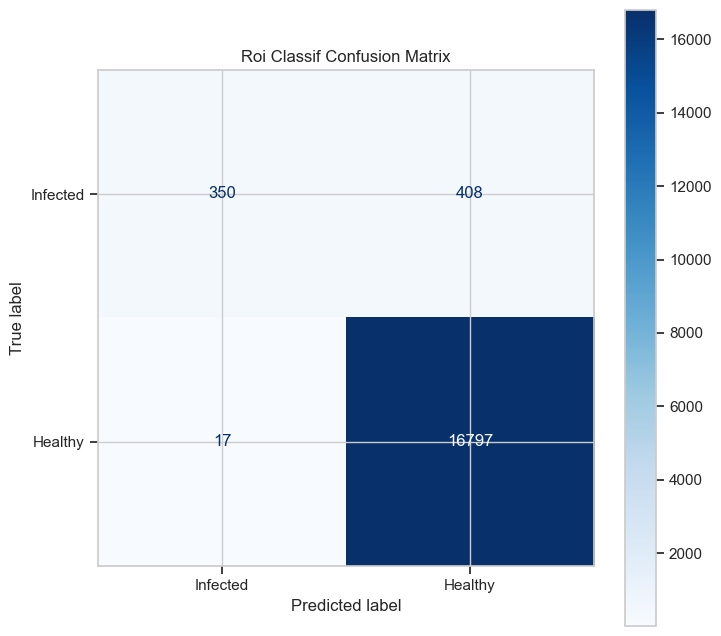

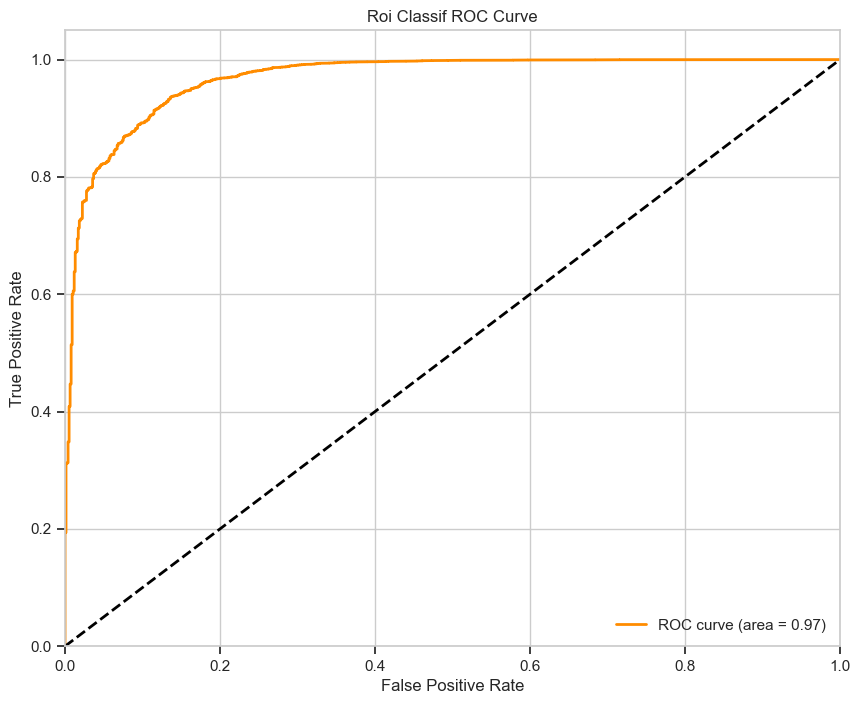


Final Metrics Summary
{
  "accuracy": 0.975813794673344,
  "f1_macro": 0.8048646018074866,
  "f1_infected": 0.6222222222222222,
  "f1_healthy": 0.9875069813927511
}
--- Experiment 7818b9ce Completed & Logged ---

Evaluation complete. Results logged to 'test_results.json' in experiments\STL\roi_classif\run_6_STL_ROI_2cls_Hybrid_NoSampler

✓ Evaluation completed successfully

STEP 10: EVALUATION COMPLETE

✓ All results have been saved to: experiments\STL\roi_classif\run_6_STL_ROI_2cls_Hybrid_NoSampler

  Key output files:
  - test_results.json (STL) or mttl_test_results.json (MTTL)
  - Various diagnostic plots and visualizations



In [ ]:
# Re-evaluate any run
import os
import sys
import json
import pickle
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
from experiment_manager import ExperimentManager
from Evaluator import AdvancedEvaluator
from IPython.display import display

# Configs and paths
print("="*80)
print("STEP 1: INITIALIZING CONFIGURATION")
print("="*80)

BASE_EXPERIMENTS_DIR = "experiments"
DATA_DIR = os.path.join("..", "data", "preprocessed_NLM", "mttl_training_data")

# Verify paths exist
if not os.path.exists(BASE_EXPERIMENTS_DIR):
    print(f"FATAL: Experiments directory '{BASE_EXPERIMENTS_DIR}' not found.")
    sys.exit(1)

if not os.path.exists(DATA_DIR):
    print(f"FATAL: Data directory '{DATA_DIR}' not found.")
    sys.exit(1)

print(f"Experiments directory: {BASE_EXPERIMENTS_DIR}")
print(f"Data directory: {DATA_DIR}")

# Load all experiments
print("\n" + "="*80)
print("STEP 2: LOADING ALL EXPERIMENTS")
print("="*80)

try:
    manager = ExperimentManager(base_dir=BASE_EXPERIMENTS_DIR)
    all_runs_df = manager.load_all_experiments()
    print(f"Successfully loaded experiments database")
except Exception as e:
    print(f"FATAL: Failed to load experiments. Error: {e}")
    sys.exit(1)

if all_runs_df.empty:
    print(f"FATAL: No experiments found in '{BASE_EXPERIMENTS_DIR}'.")
    sys.exit(1)

print(f"Found {len(all_runs_df)} total experiment records")

# get evaluatable runs
print("\n" + "="*80)
print("STEP 3: IDENTIFYING EVALUATABLE RUNS")
print("="*80)

# Create identifiers
all_runs_df['task_name'] = all_runs_df['tasks'].apply(
    lambda t: t[0] if isinstance(t, list) and len(t) > 0 else 'unknown'
)
all_runs_df['uri'] = (all_runs_df['mode'].astype(str) + '-' + 
                      all_runs_df['task_name'].astype(str) + '-' + 
                      all_runs_df['run_id'].astype(str))

# Check for saved models
all_runs_df['has_model'] = all_runs_df['directory'].apply(
    lambda d: os.path.exists(os.path.join(d, 'best_model.pth')) if pd.notna(d) else False
)

evaluable_runs = all_runs_df[all_runs_df['has_model']].copy().reset_index(drop=True)

if evaluable_runs.empty:
    print("FATAL: No evaluatable experiments with 'best_model.pth' found.")
    sys.exit(1)

print(f"Found {len(evaluable_runs)} evaluatable experiments")

# show available runs
print("\n" + "="*80)
print("STEP 4: AVAILABLE EVALUABLE EXPERIMENTS")
print("="*80)

display_cols = ['uri', 'strategy', 'status', 'timestamp_start']
display_df = evaluable_runs[display_cols].copy()
display_df.index = np.arange(len(display_df))

print("\n")
display(display_df.style.set_properties(**{'text-align': 'left'}))

# User select
print("\n" + "="*80)
print("STEP 5: SELECT EXPERIMENT TO EVALUATE")
print("="*80)

try:
    selection = int(input(f"\nEnter the index number (0-{len(evaluable_runs)-1}): "))
    
    if not (0 <= selection < len(evaluable_runs)):
        print(f"Invalid selection. Please enter a number between 0 and {len(evaluable_runs)-1}.")
        sys.exit(1)
        
except ValueError:
    print("Invalid input. Please enter a valid integer.")
    sys.exit(1)

selected_run_info = evaluable_runs.iloc[selection]
run_directory = selected_run_info['directory']

print(f"\nSelected experiment:")
print(f"  - URI: {selected_run_info['uri']}")
print(f"  - Strategy: {selected_run_info['strategy']}")
print(f"  - Mode: {selected_run_info['mode']}")
print(f"  - Status: {selected_run_info['status']}")
print(f"  - Directory: {run_directory}")

#Check selection
print("\n" + "="*80)
print("STEP 6: VERIFYING SELECTED RUN")
print("="*80)

# Check config exists
config_path = os.path.join(run_directory, 'config.json')
if not os.path.exists(config_path):
    print(f"FATAL: Config file not found at {config_path}")
    sys.exit(1)

try:
    with open(config_path, 'r') as f:
        config_run = json.load(f)
    print(f"Config loaded successfully")
    print(f"  - Mode: {config_run.get('mode', 'Unknown')}")
    print(f"  - Active tasks: {config_run.get('active_tasks', [])}")
except Exception as e:
    print(f"FATAL: Failed to load config. Error: {e}")
    sys.exit(1)

# Check model exists
model_path = os.path.join(run_directory, 'best_model.pth')
if not os.path.exists(model_path):
    print(f"FATAL: Model file not found at {model_path}")
    sys.exit(1)

print(f"Model file exists")

# load test samples
print("\n" + "="*80)
print("STEP 7: LOADING TEST DATA")
print("="*80)

try:
    test_sample_path = os.path.join(DATA_DIR, "test", "test_samples.pkl")
    
    if not os.path.exists(test_sample_path):
        print(f"FATAL: Test samples file not found at {test_sample_path}")
        sys.exit(1)
    
    with open(test_sample_path, "rb") as f:
        test_samples_full = pickle.load(f)
    
    print(f"Successfully loaded test dataset")
    print(f"  - Total test samples: {len(test_samples_full)}")
    
except Exception as e:
    print(f"FATAL: Failed to load test samples. Error: {e}")
    sys.exit(1)

# setup evaluator
print("\n" + "="*80)
print("STEP 8: INITIALIZING EVALUATOR")
print("="*80)

try:
    evaluator = AdvancedEvaluator(
        run_directory=run_directory,
        test_samples=test_samples_full
    )
    print(f"Evaluator initialized successfully")
    print(f"  - Device: {evaluator.device}")
    print(f"  - Test samples loaded: {len(evaluator.test_samples)}")
    
except Exception as e:
    print(f"FATAL: Failed to initialize evaluator. Error: {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1)

# evaluate
print("\n" + "="*80)
print("STEP 9: RUNNING COMPREHENSIVE EVALUATION")
print("="*80)

try:
    if config_run.get('mode') == 'MTTL':
        print(f"\nInitiating MTTL evaluation on FULL TEST SET ({len(test_samples_full)} samples)")
        print(f"  Tasks: {config_run.get('active_tasks', [])}")
        
        evaluator.run_mttl(
            iou_thresh=0.5, 
            conf_thresh=0.5, 
            conf_thresh_vis=0.75, 
            focus_infected=True, 
            use_roi_classifier=False
        )
        
    else:  # STL
        print(f"\nInitiating STL evaluation on FULL TEST SET ({len(test_samples_full)} samples)")
        print(f"  Task: {config_run.get('active_tasks', [None])[0]}")
        
        evaluator.run(
            iou_thresh=0.5, 
            conf_thresh=0.5, 
            conf_thresh_vis=0.75, 
            focus_infected=True
        )
    
    print(f"\nEvaluation completed successfully")
    
except Exception as e:
    print(f"ERROR: Evaluation failed. Error: {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1)

# results
print("\n" + "="*80)
print("STEP 10: EVALUATION COMPLETE")
print("="*80)

print(f"\nAll results have been saved to: {run_directory}")
print("\n" + "="*80)